## 类对象属性字典的填充

在给类对象设置完基类、以及类型信息之后，就开始填充属性字典了，这是一个非常复杂的过程。



**以整形的 \__sub__ 为例，我们知道它会对应底层的 long_sub，可虚拟机是如何知道 \__sub__ 和 long_sub 之间存在关联的呢？**

其实这种关联显然是一开始就已经定好了的，存放在一个名为 slotdefs 的数组中。

### slot 与操作排序

在进入填充tp_dict的复杂操作之前，我们先来看一个概念：slot。  

    
    
**slot 可以视为表示 PyTypeObject 中定义的操作，一个魔法函数对应一个 slot。**但是 slot 又不仅仅包含一个函数指针，它还包含一些其它信息，我们看看它的结构。在Python内部，slot 是通过 slotdef 这个结构体来实现的。
    



在一个 slot 中，就存储着PyTypeObject的一种操作对应的各种信息，比如：整数(PyLongObject)支持哪些行为，就看类型对象int(PyLong_Type)定义了哪些操作，而PyTypeObject对象中的一个操作就会有一个slot与之对应。



slot里面的 name 就是操作对应的名称，比如字符串 "\__sub__"，offset 则是操作的函数地址在XXX中的偏移量（这个XXX是什么一会说），而function则指向一种名为slot function的函数。
    
**我们看到里面又出现了PyHeapTypeObject，它又是什么？先来看看它的定义:**



**这个PyHeapTypeObject是为自定义类对象准备的**，它的第一个成员就是 PyTypeObject，至于其它的则是操作簇。至于为什么要有这么一个对象，原因是自定义类对象和相关的操作簇在内存中是连续的，必须在运行时动态分配内存，所以它是为自定义类准备的。


对于内置类对象而言，offset 表示操作的函数地址在PyTypeObject中的偏移量；

对于自定义类对象而言，offset 表示操作的函数地址在PyHeapTypeObject中的偏移量；



于是这里就产生了一个问题，假设我们定义了一个类继承自 int，根据继承关系，显然自定义的类是具有PyNumberMethods这个操作簇的，它可以使用 \__add__、\__sub__ 之类的魔法函数。
**但操作簇是定义在 PyTypeObject 里面的，而此时的 offset 却是基于 PyHeapTypeObject 得到的偏移量，那么通过这个 offset 显然无法准确找到操作簇里面的函数指针，比如 long_add、long_sub 等等。**



那我们要这个 offset 还有何用呢？**答案是这个 offset 是用来对操作进行排序的。**不过在理解为什么需要对操作进行排序之前，需要先看看底层预先定义的 slot 集合 slotdefs。

比如对于 \__getitem__，在 tp_dict 中与其对应的是 mp_subscript 还是 sq_item 呢？这两者都是通过 [] 进行操作的，比如字典根据 key 获取 value、列表基于索引获取元素，对应的都是\__getitem__。



**为了解决这个问题，就需要利用 slot 中的 offset 信息对 slot（也就是操作）进行排序。回顾一下前面列出的 PyHeapTypeObject 的定义，与一般的 struct 定义不同，它的各个成员的顺序是非常关键的，在顺序中隐含着操作优先级的问题。**



在PyHeapTypeObject中，PyMappingMethods 的位置在 PySequenceMethods 之前，mp_subscript是 PyMappingMethods 中的一个函数指针，而sq_item又是 PySequenceMethods 中的一个函数指针。**因此如果在一个PyTypeObject中，既定义了mp_subscript，又定义了sq_item，那么虚拟机将选择 mp_subscript 与 \__getitem__ 建立联系。**



In [9]:
class A(list):

    def __getitem__(self, item):
        return item

a = A([])
print(a)  
print(a[0]) 
print(a["xxx"])

[]
0
xxx


显然根据偏移量的关系，虚拟机最终选择了让 mp_subscript 和 \__getitem__ 建立联系。

### slot 变成 descriptor



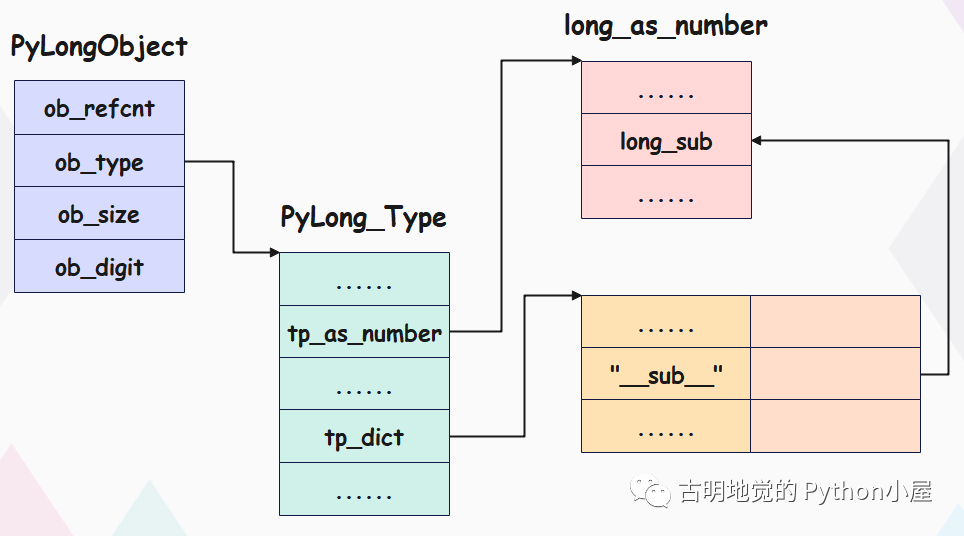
当时说 "\__sub__" 对应的 value 并不是一个直接指向 long_sub 函数的指针，而是指向一个结构体，至于指向 long_sub 函数的指针则在该结构体内部。**那么问题来了，这个结构体是不是上面的 slot 呢？**



我们知道在 slot 中，包含了很多关于一个操作的信息。但是很可惜，**在tp_dict中，与 "\__sub__" 关联在一起的，一定不会是 slot，因为它不是一个 PyObject，无法将其指针放在字典中。**

前面我们说过，**虚拟机在 tp_dict 中找到对应的操作后，会调用该操作，所以 tp_dict 中与 "\__sub__" 对应的只能是包装了 slot 的 PyObject（的指针）。在 Python 里面，我们称之为 wrapper descriptor。** 在Python内部存在多种 wrapper descriptor，一个 wrapper descriptor 包含一个 slot。

Python 内部的各种 wrapper descriptor 都会包含 PyDescrObject，也就是类型对象相关的一些信息；d_base 对应 slot；而 d_wrapped 则存放着最重要的东西：操作对应的函数指针，比如PyLong_Type，其tp_dict["\__sub__"].d_wrapped就是&long_sub。



In [11]:
print(int.__sub__)  
print(str.__add__)  
print(str.__getitem__) 

<slot wrapper '__sub__' of 'int' objects>
<slot wrapper '__add__' of 'str' objects>
<slot wrapper '__getitem__' of 'str' objects>


我们看到这些魔法函数都是一个 wrapper descriptor 对象，也就是对 slot 包装之后的描述符。wrapper descriptor 对象在底层对应 PyWrapperDescrObject，其类型是 PyWrapperDescr_Type，tp_call 为 wrapperdescr_call。

### 建立联系

**排序后的结果仍然存放在 slotdefs 中，虚拟机会从头到尾遍历 slotdefs，基于每一个 slot 建立一个 wrapper descriptor。然后在 tp_dict 中再建立从操作名到 wrapper descriptor 的关联**，这个过程是在 add_operators 中完成的。

在add_operators中，首先调用init_slotdefs对操作进行排序，然后遍历排序完成后的slotdefs数组。通过slotptr获得该slot对应的操作在PyTypeObject中的函数指针。



并紧接着创建 wrapper descriptor，然后在tp_dict中建立从操作名（slotdef.name_strobj）到操作（wrapper descriptor）的关联。



但需要注意的是，在创建 wrapper descriptor 之前，虚拟机会检查在tp_dict中是否存在同名操作。如果存在了，则不会再次建立从操作名到操作的关联。也正是这种检查机制与排序机制相结合，虚拟机才能在拥有相同操作名的多个操作中选择优先级最高的操作。

**现在我们应该能够摸清楚虚拟机在改造PyTypeObject对象时，对tp_dict做了什么了，我们以 PyLong_Type 举例说明：**
在add_operators完成之后，PyLong_Type如图所示。

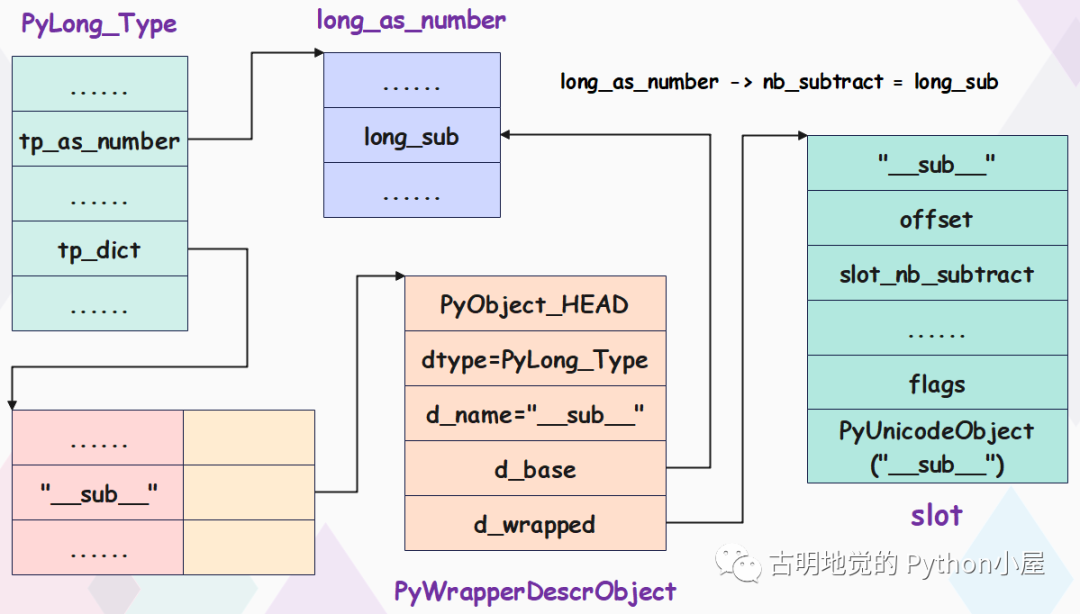





**从PyLong_Type.tp_as_number中延伸出去的部分是在编译时就已经确定好了的，而从tp_dict中延伸出去的部分则是在Python运行时环境初始化的时候才建立的。**

这个运行时环境初始化后面会单独说，现在就把它理解为解释器启动时做的准备工作即可。

另外， PyType_Ready 在通过add_operators添加了PyTypeObject中定义的一些operator后，还会通过add_methods、add_numbers和add_getsets添加 PyTypeObject 中定义的tp_methods、tp_members和tp_getset函数集。



这些过程和add_operators类似，不过最后添加到tp_dict中的就不再是 PyWrapperDescrObject ，而分别是 PyMethodDescrObject 、PyMemberDescrObject 、 PyGetSetDescrObject 。

**实例在调用函数的时候，会将函数包装成方法，它是一个 wrapper method。所以 __add__ 对于 int 类型对象而言，叫魔法函数；对于整数对象而言，叫魔法方法。**

In [12]:
print(int.__add__)
print((123).__add__)

<slot wrapper '__add__' of 'int' objects>
<method-wrapper '__add__' of int object at 0x00007FF904B53670>


### 确定 MRO



**当完成属性字典的设置，就开始确定 MRO 了，即 method resolve order。MRO 表示类继承之后，属性或方法的查找顺序。**如果Python是单继承的话，那么这不是问题，直接一层一层向上找即可。但Python是支持多继承的，那么在多继承时，继承的顺序就成为了一个必须考虑的问题。

In [13]:
class A:
    def foo(self):
        print("A")

class B(A):
    def foo(self):
        print("B")

class C(A):
    def foo(self):
        print("C")
        self.bar()

    def bar(self):
        print("bar C")

class D(C, B):
    def bar(self):
        print("bar D")

In [14]:
d = D()
d.foo()

C
bar D


首先打印的是字符串 "C"，表示调用的是 C 的 foo，说明把 C 写在前面，会先从 C 里面查找。但是下面打印了 "bar D"，这是因为 C 里面的 self 实际上是 D 的实例对象。

因为 D 在找不到 foo 函数的时候，会到父类里面找，但是同时也会将 self 传递过去。调用 self.bar 的时候，这个 self 是 D 的实例对象，所以还是会先到 D 里面找，如果找不到再去父类里面找。



**而对于虚拟机而言，则是会在PyType_Ready中通过mro_internal函数确定mro。虚拟机将创建一个PyTupleObject对象，里面存放一组类对象，这些类对象的顺序就是虚拟机确定的mro的顺序。**而这个元组，最终会被交给 tp_mro 成员保存。

由于确定 MRO 的 mro_internal 函数非常复杂，这里只要能从概念上理解它即可。另外 Python 早期有经典类和新式类两种，**现在则只存在新式类，接下来我们也只介绍新式类。**

而Python的 MRO 实际上是采用了一种叫做 C3 的算法，这个 C3 算法比较复杂（其实也不算复杂），一个更好记忆的结论是：**当沿着一条继承链寻找类时，默认会沿着该继承链一直找下去。但如果发现某个类出现在了另一条继承链当中，那么当前的继承链的搜索就会结束，然后在"最开始"出现分歧的地方转向下一条继承链的搜索。**

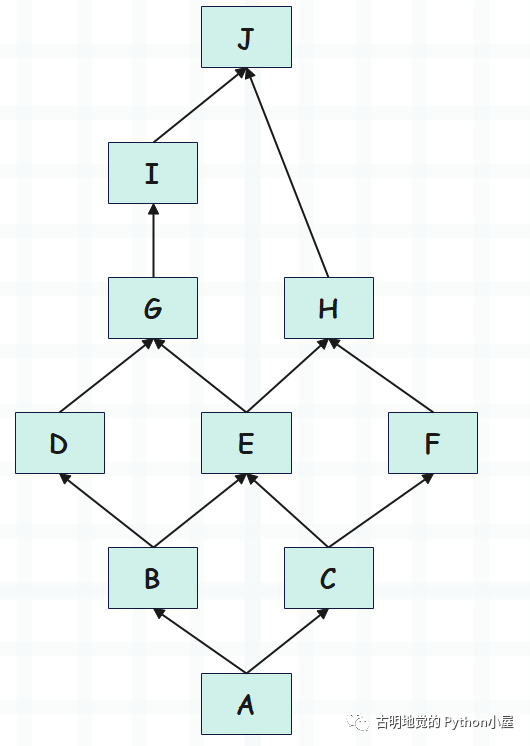

箭头表示继承关系，继承顺序是从左到右，比如这里的 A 就相当于 class A(B, C)，下面我们来从头到尾分析一下 A 的 MRO。

1）因为是 A 的 MRO，所以查找时，第一个类就是 A；

2）然后 A 继承 B 和 C，由于是两条路，因此我们说 A 这里就是一个分歧点。但由于 B 在前，所以接下来是 B，而现在 MRO 的顺序就是 A B；

3）但是 B 这里也出现了分歧点，不过不用管，因为我们说会沿着继承链不断往下搜索，现在 MRO 的顺序是A B D；

4）然后从 D 开始继续寻找，这里注意了，按理说会找到 G 的。但是 G 不止被一个类继承，也就是说沿着当前的继承链查找 G 时，发现 G 还出现在了其它的继承链当中。怎么办？显然要回到最初的分歧点，转向下一条继承链的搜索；

5）最初的分歧点是 A，那么该去找 C 了, 现在 MRO 的顺序就是 A B D C；

6）注意 C 这里也出现了分歧点，而 A 的两条分支已经结束了，所以现在 C 就是最初的分歧点了。而 C 继承自 E 和 F，显然要搜索 E，那么此时 MRO 的顺序就是 A B D C E；

7）然后从 E 开始搜索，显然要搜索 G，此时 MRO 顺序变成 A B D C E G；

8）从 G 要搜索 I，此时 MRO 的顺序是 A B D C E G I；

9）从 I 开始搜索谁呢？由于 J 出现在了其它的继承链中，那么要回到最初的分歧点，也就是 C。那么下面显然要找 F，此时 MRO 的顺序是 A B D C E G I F；

10）F 只继承了 H, 那么肯定要找 H, 此时 MRO 的顺序是 A B D C E G I F H；

11）H 显然只能找 J 了，因此最终 A 的 MRO 的顺序就是 A B D C E G I F H J object；

In [15]:
J = type("J", (object, ), {})
I = type("I", (J, ), {})
H = type("H", (J, ), {})
G = type("G", (I, ), {})
F = type("F", (H, ), {})
E = type("E", (G, H), {})
D = type("D", (G, ), {})
C = type("C", (E, F), {})
B = type("B", (D, E), {})
A = type("A", (B, C), {})

# A B D C E G I F H J
for _ in A.__mro__:
    print(_)

<class '__main__.A'>
<class '__main__.B'>
<class '__main__.D'>
<class '__main__.C'>
<class '__main__.E'>
<class '__main__.G'>
<class '__main__.I'>
<class '__main__.F'>
<class '__main__.H'>
<class '__main__.J'>
<class 'object'>


**self 在多继承里面的一些坑** ：在执行父类函数时传入的 self 参数，是很多初学者容易犯的错误。

In [16]:
class A:

    def foo(self):
        print("A: foo")
        self.bar()

    def bar(self):
        print("A: bar")

class B:

    def bar(self):
        print("B: bar")

class C(A, B):

    def bar(self):
        print("C: bar")

In [17]:
C().foo()

A: foo
C: bar
